<a href="https://colab.research.google.com/github/siddharth1292/projects/blob/main/LabAnalysis8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import scipy.optimize
import itertools,operator
from scipy.integrate import solve_ivp


In [2]:
deghr = np.rad2deg(3600)

def findOrbitFiles (startdir):
  #orbitFiles = findOrbitFiles(startdir)
  # input stardir: path to top level directory (e.g. data)
  # output list of all files that end _orbit.txt

  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python

  return sorted(glob.glob(startdir+'/**/*_orbit.txt') + glob.glob(startdir+'/*_orbit.txt') )


# Checking data validity (no wild outliers)
def sanityCheck(time, theta, amplitude, number, maxTime = np.inf):
  dt = np.gradient(time)
  #dtheta = np.gradient(np.unwrap(theta),time)
  
  #damplitude = np.diff(np.log(amplitude))
  amprange = (30,75)
  dn = np.gradient(number)
  maxgap = 7200 
  valid = ((dt > 0) & (dt < maxgap) & (dn > 0) & (amplitude > amprange[0]) & (amplitude < amprange[1])) #np.abs(damplitude) < np.log(2) 
  return valid
  

# load slope and get longest valid sequence
# takes the absolute value of slope 
# inputs: filepath - path of the file
#         maxTime - optional, longest duration to load
# outputs: time - time of the crossing: (file contains every other crossing, e.g. 1 per period)
#          slope - absolute value of slope at the crossing (V/s)
#          majaxis - major axis (mm)
#          minaxis - minor axis (mm)
#          
def loadOrbitFile(filepath, maxTime = 10000000):
  #num crossings	time (s)	maj axis (mm)	min axis (mm)	theta (rad )	slope (V/s)
  num, time, majaxis, minaxis, theta, slope = np.loadtxt(filepath, skiprows = 1, unpack=True)
  validInds = sanityCheck(time,theta,majaxis,num,maxTime)
  num = num[validInds]
  time = time[validInds]
  theta = np.unwrap(theta[validInds])
  time = time - time[0] #0 reference time
  majaxis = majaxis[validInds]
  minaxis = minaxis[validInds]
  slope = np.abs(slope[validInds])

  return (time,theta,majaxis,minaxis)

def splineSmoothAndDerivative(t,y, s = 10, dt = 10):
  tck = scipy.interpolate.splrep(t, scipy.ndimage.median_filter(y, size=(5,)), s=s)
  xnew = np.arange(t[0],t[-1],dt)
  return xnew, scipy.interpolate.splev(xnew, tck, der=0),  scipy.interpolate.splev(xnew, tck, der=1) 


In [3]:
# MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY by replacing "your_github_username" with your github user name 
# DO NOT delete the "data" at the end of the line 
!git clone https://github.com/NYU-IEP-2022-3-Classroom/LongFoucaultDataSets data
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab8-data-repository-siddharth1292 mydata 




Cloning into 'data'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 6), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (20/20), 9.55 MiB | 3.17 MiB/s, done.
Cloning into 'mydata'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 1), reused 28 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 7.96 MiB | 6.67 MiB/s, done.


#This code loads and smooths your data

`rawtime` and `rawtheta` contain the time and orbit angle as determined by the labview fitter

`time`, `theta` give a smoothed version of the orbit angle in 10 second increments (the angle is first median filtered to eliminate large random jumps then a smoothing spline is used to further smooth the angle) and `dthetadt` contains the derivative of the smoothed angle (in radians/sec)

In [21]:
of = findOrbitFiles('mydata')
(rawtime, rawtheta, rawma, rawb) = loadOrbitFile(of[0])

rawtime=rawtime[rawtheta>-4.5]
rawma=rawma[rawtheta>-4.5]
rawb=rawb[rawtheta>-4.5]
rawtheta=rawtheta[rawtheta>-4.5]

time, theta, dthetadt = splineSmoothAndDerivative(rawtime,rawtheta)


#Plot the angle of the orbit vs time

`rawtime` and `rawtheta` contain the time and orbit angle as determined by the labview fitter

`time`, `theta` give a smoothed version of the orbit angle in 10 second increments (the angle is first median filtered to eliminate large random jumps then a smoothing spline is used to further smooth the angle) and `dthetadt` contains the derivative of the smoothed angle (in radians/sec)

1. Please plot the raw angle vs. (raw) time, and the smoothed angle vs. the smoothed time. **Make the time in hours and the angle in degrees** (1 second = 1/3600 hours, 1 radian is 180/$\pi$ degrees (or use np.rad2deg)). Label the axes. 

1. Please fit the smoothed angle to a linear function of smoothed time (find the best fit line of the form $\theta = m*t + b$). Plot this line fit on top of the other two curves (remember to convert time to hours and angle to degrees). 

1. Title the plot with the slope of the line, converted to degrees per hr. (Depending on whether you converted units before or after you did the fit, your result might already be in degrees per hour. Otherwise, 1 radian per second = `np.rad2deg(3600)` degrees per hr, or multiply by `deghr`, which I've defined for you)

#Plot the rate of change of the angle vs time
1. On a new set of axes, please plot the derivative of the smoothed angle vs time. Please convert time to hours and precession rate to degrees per hour. Plot a horizontal line across the data at the rate determined by your fit above. (i.e. if the fit slope was -8 degrees per hour, you would plot a horizontal line at -8 degrees per hour)



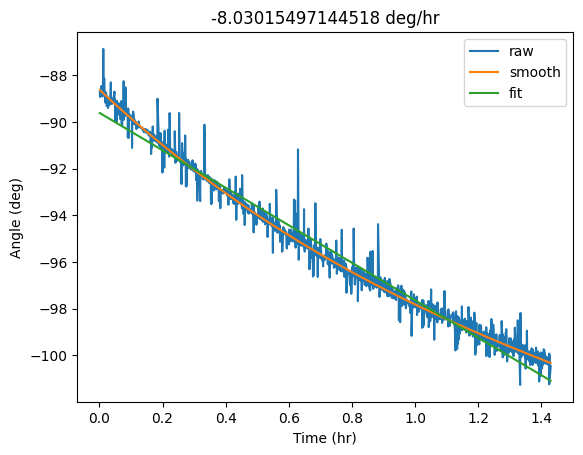

In [22]:
#your code here
plt.plot(rawtime/3600,(rawtheta*180/np.pi),label = 'raw')
plt.plot(time/3600,(theta*180/np.pi), label = 'smooth')
plt.xlabel('Time (hr)')
plt.ylabel('Angle (deg)')

p = np.polyfit(time/3600,(theta*180/np.pi),1)
plt.plot(time/3600,p[0]*time/3600+p[1],label='fit')
plt.title(f'{p[0]} deg/hr')
plt.legend()

#If your data looks OK, please add it to the shared repository

By OK, I mean that you have at least an hour of measurements, your angle vs. time doesn't look like it was collected on the deck of a battleship conducting evasive maneuvers in the middle of a hurricane, and you are able to complete the first part of the lab analysis without errors that need to be corrected by hand. 

Please use the link below to accept the shared repository, then copy **your _orbit.txt file(s)** only to the shared repository. 

[Assignment link](https://classroom.github.com/a/0Hajlpy_)

#Write a function that loads an orbit file from disk, fits the angle vs time to a line, then returns the slope of that line

Encapsulate your previous work (without the plotting) to find the mean precession rate in degrees per hour for a single file. Check to make sure you get the correct result for your file

In [23]:
def precessionRate(filename):
  (rawtime, rawtheta, rawma, rawb) = loadOrbitFile(filename)
  time, theta, dthetadt = splineSmoothAndDerivative(rawtime,rawtheta)
  p = np.polyfit(time/3600,(theta*180/np.pi),1)
  return p[0]

print ('As a check, here is the precession rate of the data you previously analyzed {:.2f} deg/hr'.format(precessionRate(of[0])))

As a check, here is the precession rate of the data you previously analyzed -8.04 deg/hr


This code will fetch the class repository, run your function on every data set in it, and store the resulting fit precession rates in a numpy array `precession_rates`

In [24]:
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab8-shared-data-everyone alldata
allOrbits = findOrbitFiles('alldata')
precession_rates = np.array([precessionRate(f) for f in allOrbits])

Cloning into 'alldata'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), 55.66 KiB | 982.00 KiB/s, done.


#Make a histogram of the measured rates

Title the histogram with the mean and standard error of the mean of the precession rates. 

This will change as more people add data to the repository, so be sure to check back and rerun your notebook later to see what the final outcome is

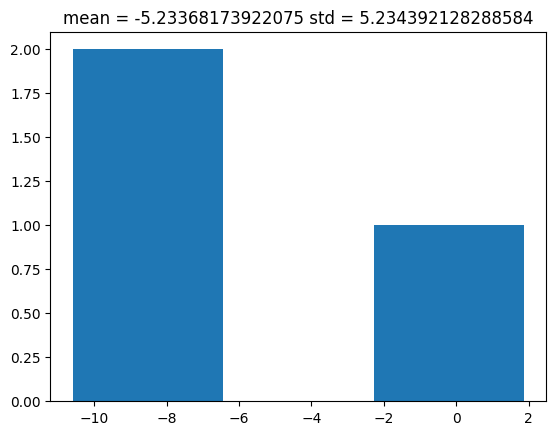

In [25]:
#your code here
plt.hist(precession_rates,bins='auto')
mean = np.mean(precession_rates)
std = np.std(precession_rates)
plt.title(f'mean = {mean} std = {std}');

#Look at a longer recording

Here are some longer recordings to play with

In [26]:
!rm -rf longdata
!git clone https://github.com/NYU-IEP-2022-3-Classroom/LongFoucaultDataSets longdata
longFiles = findOrbitFiles('longdata')
print(longFiles)

Cloning into 'longdata'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 6), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (20/20), 9.55 MiB | 4.96 MiB/s, done.
['longdata/20230428121448_orbit.txt', 'longdata/20230428124437_orbit.txt', 'longdata/labannex_weekend_orbit.txt', 'longdata/marc_desk_week_orbit.txt', 'longdata/station4_weekend_orbit.txt']


#Analyze a long data file of your choice 

e.g. look at `longFiles[0]` (or `[1]` or...)

1. Load and smooth the data (`loadOrbitFile` and `splineSmoothAndDerivative`)
1. Plot the smoothed angle (in deg) vs time (in hrs), and plot a fit line to that data. Title the plot with the slope in deg/hr 
1. On a new set of axes, plot the smoothed derivative of angle (in deg/hr) vs. time in hours

(hint: for these steps, you can cut and paste a lot of code from above)

Now look for a pattern in the data

1. Plot the derivative of the angle vs. time mod 24hrs (`np.mod(..)`), which means that the same time of day will show up at the same position on the x axis

1. On a new set of axes, plot the derivative of the anlge vs. the angle (in degrees) mod 180 - this means the same orbital direction will show up at the same position on the x axis (why 180 and not 360?)

Once you've written  this code, it's pretty easy to wrap it in a for loop or change which file you're looking at by hand, and have a look at all the sets. But I won't make you.

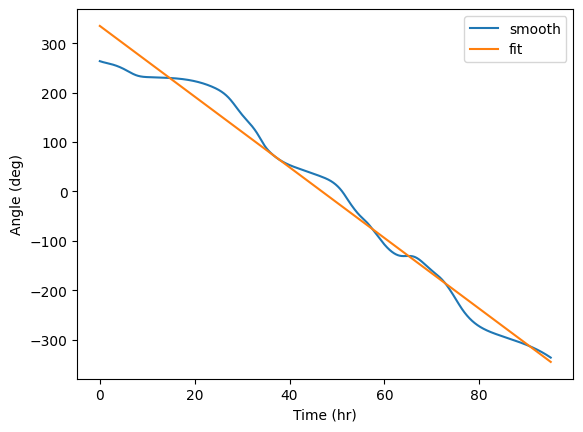

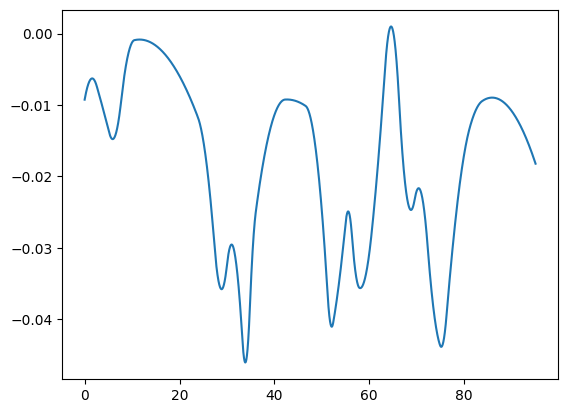

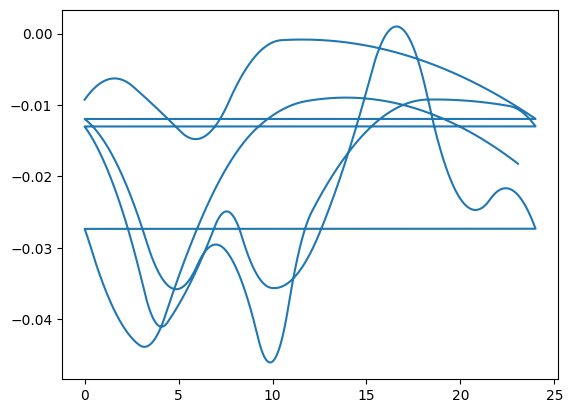

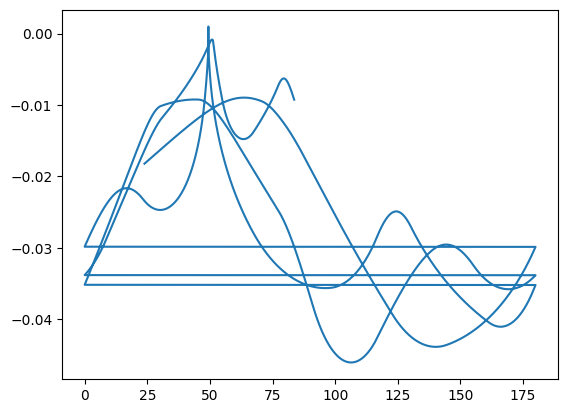

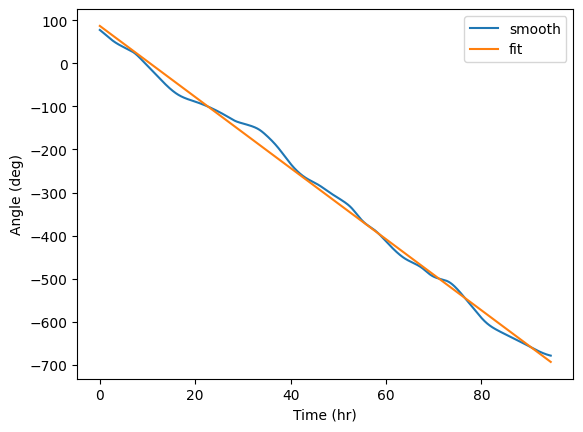

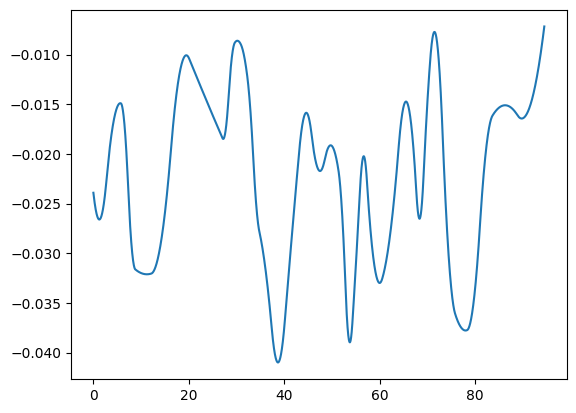

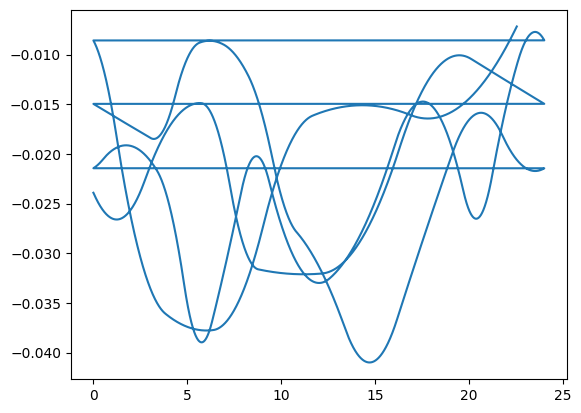

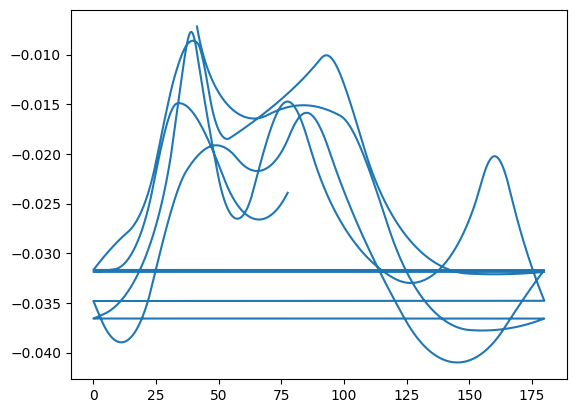

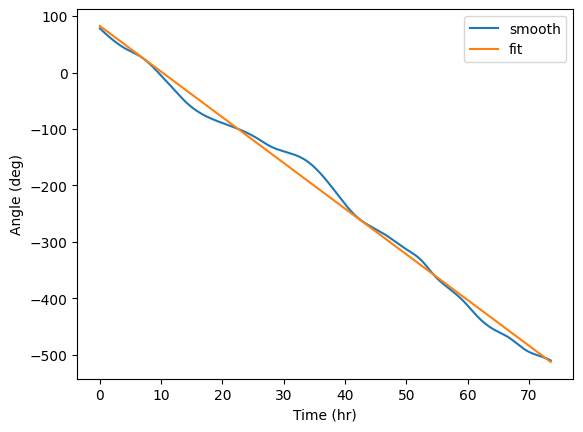

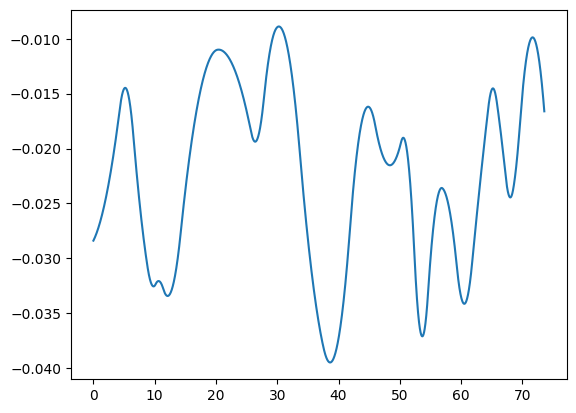

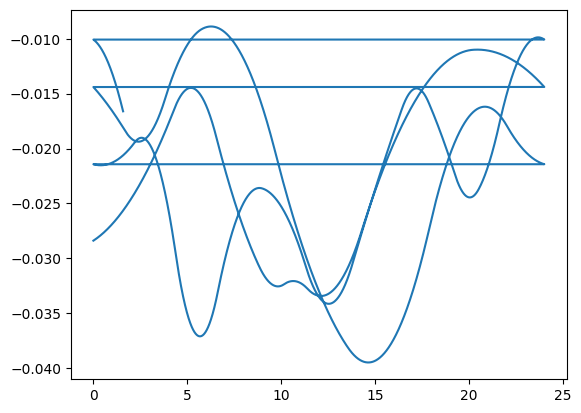

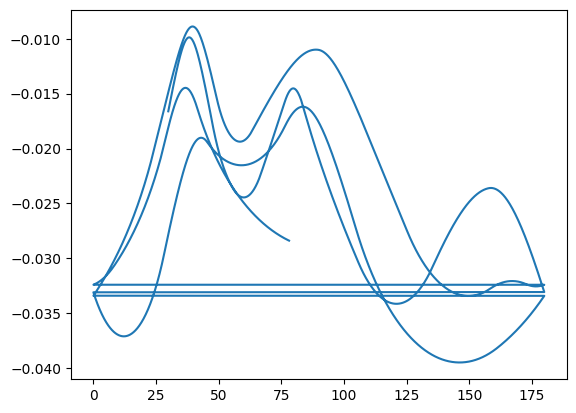

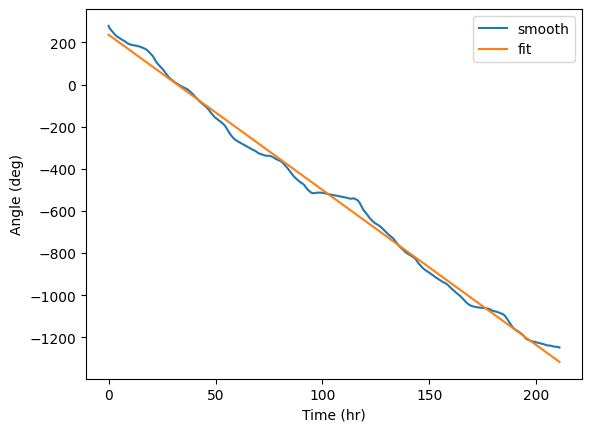

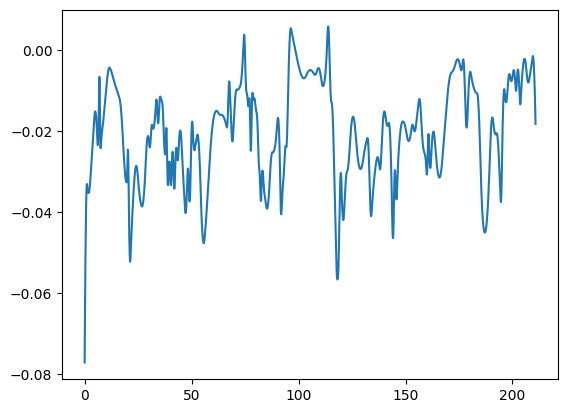

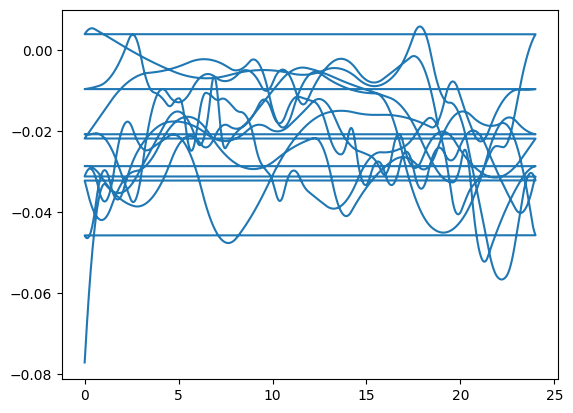

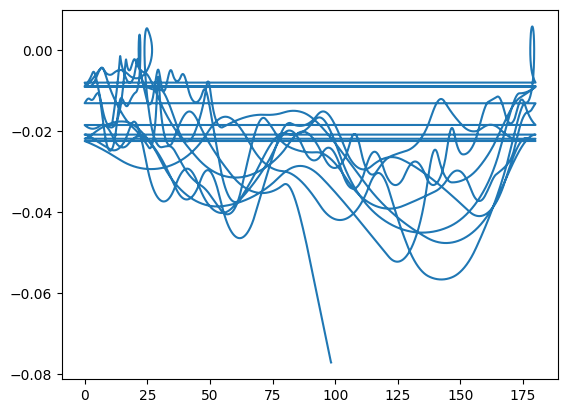

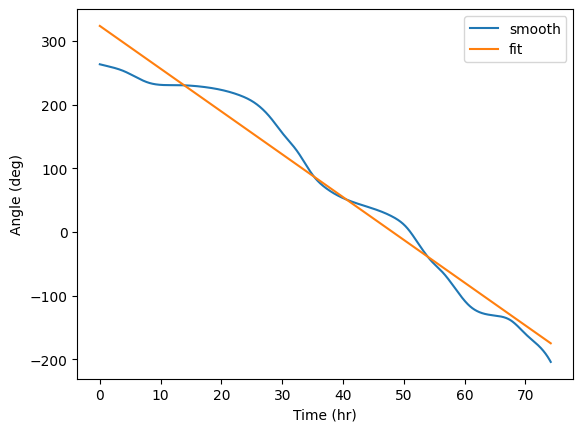

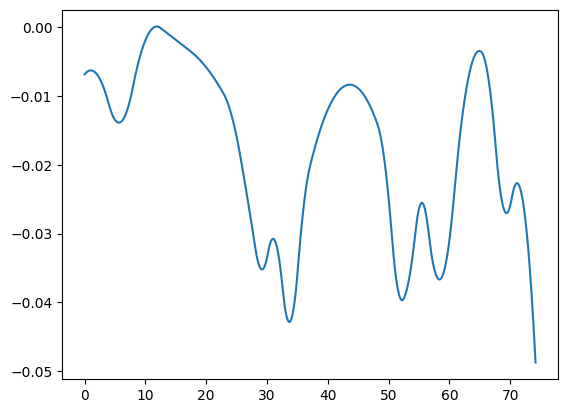

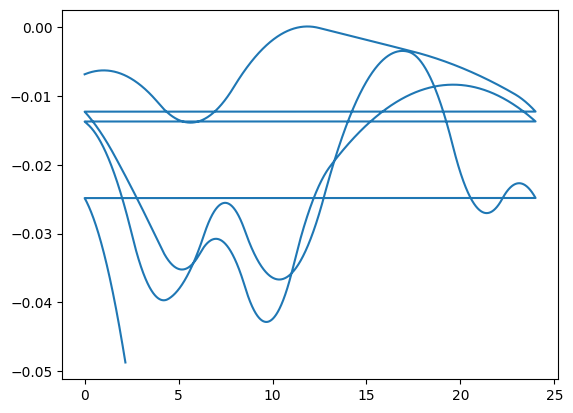

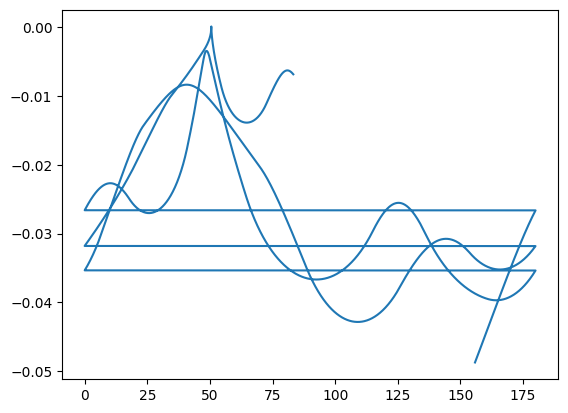

In [30]:
#your code here
for i in range(len(longFiles)):
  (rawtime, rawtheta, rawma, rawb) = loadOrbitFile(longFiles[i])
  time, theta, dthetadt = splineSmoothAndDerivative(rawtime,rawtheta)
  plt.plot(time/3600,(theta*180/np.pi), label = 'smooth')
  plt.xlabel('Time (hr)')
  plt.ylabel('Angle (deg)')
  p = np.polyfit(time/3600,(theta*180/np.pi),1)
  plt.plot(time/3600,p[0]*time/3600+p[1],label='fit')
  plt.legend()
  plt.show()
  plt.plot(time/3600,np.gradient(theta*180/np.pi), label='derivative')
  plt.show()
  plt.plot((time/3600)%24,np.gradient(theta*180/np.pi), label='mod 24')
  plt.show()
  plt.plot((theta*180/np.pi)%180,np.gradient(theta*180/np.pi))
  plt.show()

#Questions

1. Does the data support the proposition that the earth is rotating? If so, in which direction?

Yes, the data does support the proposition that the earth is rotating. It appears to be rotating in the counterclockwise direction.
1. Does the data support the proposition that the earth rotates 15 degrees per hour (or that the rate in NYC is -9.8 deg/hr)? What range of rotation rates would be consistent with the measurements?

Looking at the plots and especially my first plot, it seems entirely plausible that the the rate is -9.8 deg/hr. 
1. Do fluctuations in the rate of precession appear to be determined more by the time of day or by the geometry of the setup?

They appear to be determined more by the geometry of the setup. If we look at the graph of the derivative, we see a spike at a cetain angle which could be attributed to the fact that there is a magnetic tube running along the wall of the class and this imaprted a force on the bob.